In [52]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NULL_SUBCARRIERS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 64, 65, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]

In [3]:
connection = sqlite3.connect("../database/rti.db")

In [4]:
cursor = connection.cursor()

In [5]:
data = pd.read_csv("../testing-data/2024-04-11-14-37-23.csv")

In [6]:
# Define a function to remove null subcarriers
def remove_null_subcarriers(csi_list):
    return [value for index, value in enumerate(csi_list) if index not in NULL_SUBCARRIERS]

In [ ]:
results = pd.DataFrame(columns=["subcarrier", "hits", "misses"])
for i in range(int(len(data)/5)):
    data_rows = data.iloc[i:i+5]

    #remove null subcarriers
    data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)

    possible_voxels = data_rows["voxel_no"].unique()
    actual_voxel = np.bincount(possible_voxels).argmax()
    
    # Calculate amplitude and phase using vectorized operations
    csi_array = np.array(data_rows['csi'].tolist())
    amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
    phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

    #Calculate vectors for each subcarrier
    vectors = pd.DataFrame()
    for subcarrier in range(1, 53):
        subcarrier_amplitudes = []
        subcarrier_phases = []
        for index in range(5):
            subcarrier_amplitudes.append(amplitudes[index][subcarrier-1])
            subcarrier_phases.append(phases[index][subcarrier-1])
        row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
        vectors = pd.concat([vectors, row_to_append])
    
    euclidean_distances = pd.DataFrame()
    for _, row in vectors.iterrows(): #for each subcarrier
        #for each voxel get the vector for each specific subcarrier
        subcarrier = row['subcarrier']
        for voxel in range(1, 10):
            res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, "Standing-Movement"])
            result = res_cursor.fetchone()
            amplitude_vector = np.array(eval(result[3]))
            phase_vector = np.array(eval(result[4]))
            # Calculate Euclidean distance
            amplitude_euclidean_distance = np.linalg.norm(row['amplitude'] - amplitude_vector)
            phase_euclidean_distance = np.linalg.norm(np.array(row['phase']) - phase_vector)
            row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': "Standing-Movement", 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
            euclidean_distances = pd.concat([euclidean_distances, row_to_append])

        #Calculate accuracy per subcarrier
        subcarrier_data = euclidean_distances[(euclidean_distances["subcarrier"] == subcarrier)]
        estimated_voxel = subcarrier_data[subcarrier_data["phase_diff"] == subcarrier_data["phase_diff"].min()]["voxel"][0]
        
        hit = 0
        miss = 1
        if estimated_voxel == actual_voxel:
            hit = 1
            miss = 0

        res = results[results["subcarrier"] == subcarrier]
        if res.empty:
            new = pd.DataFrame([{"subcarrier": subcarrier, "hits": hit, "misses": miss}])
            results = pd.concat([results, new])
        else:
            results.loc[results["subcarrier"] == subcarrier, "hits"] = res["hits"] + hit
            results.loc[results["subcarrier"] == subcarrier, "misses"] = res["misses"] + miss

In [189]:
results = pd.DataFrame(columns=["subcarrier", "hits", "misses", "accuracy"])
activity = "Standing-Stationary"
for i in range(80):
    data_rows = data.iloc[i:i+5]

    #remove null subcarriers
    data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)

    possible_voxels = data_rows["voxel_no"].unique()
    actual_voxel = np.bincount(possible_voxels).argmax()
    
    # Calculate amplitude and phase using vectorized operations
    csi_array = np.array(data_rows['csi'].tolist())
    amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
    phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

    #Calculate vectors for each subcarrier
    vectors = pd.DataFrame()
    for subcarrier in range(1, 53):
        subcarrier_amplitudes = []
        subcarrier_phases = []
        for index in range(5):
            subcarrier_amplitudes.append(amplitudes[index][subcarrier-1])
            subcarrier_phases.append(phases[index][subcarrier-1])
        row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
        vectors = pd.concat([vectors, row_to_append])
    
    euclidean_distances = pd.DataFrame()
    for _, row in vectors.iterrows(): #for each subcarrier
        #for each voxel get the vector for each specific subcarrier
        subcarrier = row['subcarrier']
        for voxel in range(1, 10):
            res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, activity])
            result = res_cursor.fetchone()
            amplitude_vector = np.array(eval(result[3]))
            phase_vector = np.array(eval(result[4]))
            # Calculate Euclidean distance
            amplitude_euclidean_distance = np.linalg.norm(row['amplitude'] - amplitude_vector)
            phase_euclidean_distance = np.linalg.norm(np.array(row['phase']) - phase_vector)
            row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': activity, 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
            euclidean_distances = pd.concat([euclidean_distances, row_to_append])

        #Calculate accuracy per subcarrier
        subcarrier_data = euclidean_distances[(euclidean_distances["subcarrier"] == subcarrier)]
        estimated_voxel = subcarrier_data[subcarrier_data["amplitude_diff"] == subcarrier_data["amplitude_diff"].min()]["voxel"][0]
        
        hit = 0
        miss = 1
        if estimated_voxel == actual_voxel:
            hit = 1
            miss = 0

        res = results[results["subcarrier"] == subcarrier]
        if res.empty:
            new = pd.DataFrame([{"subcarrier": subcarrier, "hits": hit, "misses": miss}])
            results = pd.concat([results, new])
        else:
            results.loc[results["subcarrier"] == subcarrier, "hits"] = res["hits"] + hit
            results.loc[results["subcarrier"] == subcarrier, "misses"] = res["misses"] + miss
        results.loc[results["subcarrier"] == subcarrier, "accuracy"] = ((res["hits"] + hit) / (res["hits"] + res["misses"] + hit + miss) * 100)

/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_31688/3616361096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_31688/3616361096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_31688/3616361096.py:7: SettingWithCopyW

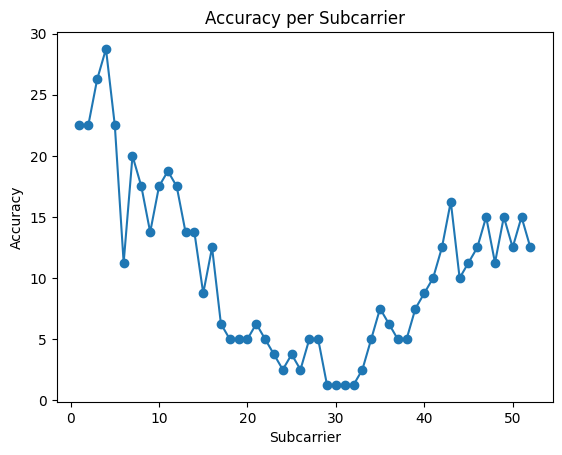

In [193]:
# Assuming 'results' DataFrame is available
plt.plot(results["subcarrier"], results["accuracy"], marker='o', linestyle='-')
plt.xlabel('Subcarrier')
plt.ylabel('Accuracy')
plt.title('Accuracy per Subcarrier')
plt.show()

In [102]:
results = pd.DataFrame(columns=["subcarrier", "hits", "misses", "accuracy"])
accuracy = pd.DataFrame(columns=["hits", "misses", "estimates", "most_predicted_voxel", "most_predicted_voxel_count", "actual_voxel"])
hits = 0
misses = 0
activity = "Walking"
for i in range(0, 400, 5):
    data_rows = data.iloc[i:i+5]

    #remove null subcarriers
    data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)

    possible_voxels = data_rows["voxel_no"].unique()
    actual_voxel = np.bincount(possible_voxels).argmax()
    
    # Calculate amplitude and phase using vectorized operations
    csi_array = np.array(data_rows['csi'].tolist())
    amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
    phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

    #Calculate vectors for each subcarrier
    vectors = pd.DataFrame()
    for subcarrier in range(1, 53):
        subcarrier_amplitudes = []
        subcarrier_phases = []
        for index in range(5):
            subcarrier_amplitudes.append(amplitudes[index][subcarrier-1])
            subcarrier_phases.append(phases[index][subcarrier-1])
        row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
        vectors = pd.concat([vectors, row_to_append])
    
    euclidean_distances = pd.DataFrame()
    estimates = []
    for _, row in vectors.iterrows(): #for each subcarrier
        #for each voxel get the vector for each specific subcarrier
        subcarrier = row['subcarrier']
        for voxel in range(1, 10):
            res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, activity])
            result = res_cursor.fetchone()
            amplitude_vector = np.array(eval(result[3]))
            phase_vector = np.array(eval(result[4]))
            # Calculate dot product
            amplitude_euclidean_distance = np.dot(np.array(row['amplitude']), amplitude_vector)
            phase_euclidean_distance = np.dot(np.array(row['phase']), phase_vector)
            row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': activity, 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
            euclidean_distances = pd.concat([euclidean_distances, row_to_append])

        #Calculate accuracy per subcarrier
        subcarrier_data = euclidean_distances[(euclidean_distances["subcarrier"] == subcarrier)]
        estimated_voxel = subcarrier_data[subcarrier_data["phase_diff"] == subcarrier_data["phase_diff"].min()]["voxel"][0]
        estimates.append(estimated_voxel)

    count = estimates.count(actual_voxel)
    most_predicted = np.bincount(estimates).argmax()
    estimates_dict = dict.fromkeys(range(1,10))
    for i in range (1, 10, 1):
        estimates_dict[i] = estimates.count(i)
    append_row = pd.DataFrame([{'hits': count, "misses": len(estimates) - count, "estimates": estimates_dict, 'most_predicted_voxel': most_predicted, "most_predicted_voxel_count": estimates.count(most_predicted), "actual_voxel": actual_voxel}])
    accuracy = pd.concat([accuracy, append_row])
    if count >= (len(estimates)/2):
        hits = hits + 1
    else:
        misses = misses + 1

/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/522793179.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/522793179.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/522793179.py:10: SettingWithCopyWarn

In [72]:
results = pd.DataFrame(columns=["subcarrier", "hits", "misses", "accuracy"])
accuracy = pd.DataFrame(columns=["hits", "misses", "estimates", "most_predicted_voxel", "most_predicted_voxel_count", "actual_voxel"])
hits = 0
misses = 0
activity = "SittingDown-Stationary"
for i in range(0, 400, 5):
    data_rows = data.iloc[i:i+5]

    #remove null subcarriers
    data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)

    possible_voxels = data_rows["voxel_no"].unique()
    actual_voxel = np.bincount(possible_voxels).argmax()
    
    # Calculate amplitude and phase using vectorized operations
    csi_array = np.array(data_rows['csi'].tolist())
    amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
    phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

    #Calculate vectors for each subcarrier
    vectors = pd.DataFrame()
    for subcarrier in range(1, 53):
        subcarrier_amplitudes = []
        subcarrier_phases = []
        for index in range(5):
            subcarrier_amplitudes.append(amplitudes[index][subcarrier-1])
            subcarrier_phases.append(phases[index][subcarrier-1])
        row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
        vectors = pd.concat([vectors, row_to_append])
    
    euclidean_distances = pd.DataFrame()
    estimates = []
    for _, row in vectors.iterrows(): #for each subcarrier
        #for each voxel get the vector for each specific subcarrier
        subcarrier = row['subcarrier']
        for voxel in range(1, 10):
            res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, activity])
            result = res_cursor.fetchone()
            amplitude_vector = np.array(eval(result[3]))
            phase_vector = np.array(eval(result[4]))
            # Calculate Euclidean distance
            amplitude_euclidean_distance = np.linalg.norm(row['amplitude'] - amplitude_vector)
            phase_euclidean_distance = np.linalg.norm(np.array(row['phase']) - phase_vector)
            row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': activity, 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
            euclidean_distances = pd.concat([euclidean_distances, row_to_append])

        #Calculate accuracy per subcarrier
        subcarrier_data = euclidean_distances[(euclidean_distances["subcarrier"] == subcarrier)]
        estimated_voxel = subcarrier_data[subcarrier_data["amplitude_diff"] == subcarrier_data["amplitude_diff"].min()]["voxel"][0]
        estimates.append(estimated_voxel)

    count = estimates.count(actual_voxel)
    most_predicted = np.bincount(estimates).argmax()
    estimates_dict = dict.fromkeys(range(1,10))
    for i in range (1, 10, 1):
        estimates_dict[i] = estimates.count(i)
    append_row = pd.DataFrame([{'hits': count, "misses": len(estimates) - count, "estimates": estimates_dict, 'most_predicted_voxel': most_predicted, "most_predicted_voxel_count": estimates.count(most_predicted), "actual_voxel": actual_voxel}])
    accuracy = pd.concat([accuracy, append_row])
    if count >= (len(estimates)/2):
        hits = hits + 1
    else:
        misses = misses + 1

/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/1641877645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/1641877645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/1641877645.py:10: SettingWithCopyW

In [33]:
accuracy

,hits,misses,estimates,most_predicted_voxel,most_predicted_voxel_count,actual_voxel
0,52,0,"{1: 52, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8:...",1,52,1
0,17,35,"{1: 17, 2: 0, 3: 0, 4: 0, 5: 0, 6: 32, 7: 1, 8...",6,32,1
0,25,27,"{1: 25, 2: 0, 3: 7, 4: 18, 5: 0, 6: 0, 7: 0, 8...",1,25,1
0,0,52,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 22, 6: 25, 7: 5, 8...",6,25,1
0,0,52,"{1: 0, 2: 1, 3: 0, 4: 19, 5: 0, 6: 0, 7: 0, 8:...",8,32,1
...,...,...,...,...,...,...
0,11,41,"{1: 0, 2: 0, 3: 0, 4: 0, 5: 41, 6: 11, 7: 0, 8...",5,41,6
0,5,47,"{1: 7, 2: 2, 3: 0, 4: 0, 5: 37, 6: 5, 7: 0, 8:...",5,37,6
0,0,52,"{1: 28, 2: 2, 3: 0, 4: 13, 5: 0, 6: 0, 7: 0, 8...",1,28,6
0,39,13,"{1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 39, 7: 11, 8...",6,39,6


In [87]:
sitting_down_stationary_accuracy = 0
for _, row in accuracy.iterrows():
    if row["hits"] > row["misses"]:
        sitting_down_stationary_accuracy = sitting_down_stationary_accuracy + 1
    else:
        if row["hits"] > row["most_predicted_voxel_count"]:
            sitting_down_stationary_accuracy = sitting_down_stationary_accuracy + 1
sitting_down_stationary_accuracy

9

In [91]:
sitting_down_movement_accuracy = 0
for _, row in accuracy.iterrows():
    if row["hits"] > row["misses"]:
        sitting_down_movement_accuracy = sitting_down_movement_accuracy + 1
    else:
        if row["hits"] > row["most_predicted_voxel_count"]:
            sitting_down_movement_accuracy = sitting_down_movement_accuracy + 1
sitting_down_movement_accuracy

13

In [95]:
standing_stationary_accuracy = 0
for _, row in accuracy.iterrows():
    if row["hits"] > row["misses"]:
        standing_stationary_accuracy = standing_stationary_accuracy + 1
    else:
        if row["hits"] > row["most_predicted_voxel_count"]:
            standing_stationary_accuracy = standing_stationary_accuracy + 1
standing_stationary_accuracy

4

In [99]:
standing_movement_accuracy = 0
for _, row in accuracy.iterrows():
    if row["hits"] > row["misses"]:
        standing_movement_accuracy = standing_movement_accuracy + 1
    else:
        if row["hits"] > row["most_predicted_voxel_count"]:
            standing_movement_accuracy = standing_movement_accuracy + 1
standing_movement_accuracy

13

In [103]:
walking_accuracy = 0
for _, row in accuracy.iterrows():
    if row["hits"] > row["misses"]:
        walking_accuracy = walking_accuracy + 1
    else:
        if row["hits"] > row["most_predicted_voxel_count"]:
            walking_accuracy = walking_accuracy + 1
walking_accuracy

5

In [186]:
accuracy[(accuracy["actual_voxel"]) == 3]

,hits,misses,most_predicted_voxel,most_predicted_voxel_count,actual_voxel
0,1,51,8,26,3
0,0,52,6,35,3
0,44,8,3,44,3
0,0,52,1,48,3
0,10,42,4,39,3
0,0,52,8,31,3
0,0,52,5,25,3
0,0,52,8,24,3
0,0,52,6,28,3
0,8,44,5,19,3


In [81]:
activities = ["Standing-Stationary", "Standing-Movement", "Walking", "SittingDown-Stationary", "SittingDown-Movement"]
results = pd.DataFrame(columns=["subcarrier", "activity", "accuracy", "hits", "misses"])

for activity in activities:
    for i in range(0, 400, 5):
        data_rows = data.iloc[i:i+5]

        #remove null subcarriers
        data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)

        possible_voxels = data_rows["voxel_no"].unique()
        actual_voxel = np.bincount(possible_voxels).argmax()
        
        # Calculate amplitude and phase using vectorized operations
        csi_array = np.array(data_rows['csi'].tolist())
        amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
        phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

        #Calculate vectors for each subcarrier
        vectors = pd.DataFrame()
        for subcarrier in range(1, 53):
            subcarrier_amplitudes = []
            subcarrier_phases = []
            for index in range(5):
                subcarrier_amplitudes.append(amplitudes[index][subcarrier-1])
                subcarrier_phases.append(phases[index][subcarrier-1])
            row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
            vectors = pd.concat([vectors, row_to_append])
        
        euclidean_distances = pd.DataFrame()
        for _, row in vectors.iterrows(): #for each subcarrier
            #for each voxel get the vector for each specific subcarrier
            subcarrier = row['subcarrier']
            for voxel in range(1, 10):
                res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, activity])
                result = res_cursor.fetchone()
                amplitude_vector = np.array(eval(result[3]))
                phase_vector = np.array(eval(result[4]))
                # Calculate Euclidean distance
                amplitude_euclidean_distance = np.linalg.norm(row['amplitude'] - amplitude_vector)
                phase_euclidean_distance = np.linalg.norm(np.array(row['phase']) - phase_vector)
                row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': activity, 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
                euclidean_distances = pd.concat([euclidean_distances, row_to_append])

            #Calculate accuracy per subcarrier
            subcarrier_data = euclidean_distances[(euclidean_distances["subcarrier"] == subcarrier)]
            estimated_voxel = subcarrier_data[subcarrier_data["phase_diff"] == subcarrier_data["phase_diff"].min()]["voxel"][0]
            
            hit = 0
            miss = 1
            if estimated_voxel == actual_voxel:
                hit = 1
                miss = 0
            res = results[(results["subcarrier"] == subcarrier) & (results['activity'] == activity)]
            if res.empty:
                new = pd.DataFrame([{"subcarrier": subcarrier, "hits": hit, "misses": miss, "activity": activity}])
                results = pd.concat([results, new])
            else:
                results.loc[(results["subcarrier"] == subcarrier) & (results["activity"] == activity), "hits"] = res["hits"] + hit
                results.loc[(results["subcarrier"] == subcarrier)  & (results["activity"] == activity), "misses"] = res["misses"] + miss
            results.loc[(results["subcarrier"] == subcarrier) & (results["activity"] == activity), "accuracy"] = ((res["hits"] + hit) / (res["hits"] + res["misses"] + hit + miss) * 100)

/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/850853286.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/850853286.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/850853286.py:9: SettingWithCopyWarning

In [109]:
activities = ["Standing-Stationary", "Standing-Movement", "Walking", "SittingDown-Stationary", "SittingDown-Movement"]
results = pd.DataFrame(columns=["subcarrier", "activity", "accuracy", "hits", "misses"])

for activity in activities:
    for i in range(0, 400, 5):
        data_rows = data.iloc[i:i+5]

        #remove null subcarriers
        data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)

        possible_voxels = data_rows["voxel_no"].unique()
        actual_voxel = np.bincount(possible_voxels).argmax()
        
        # Calculate amplitude and phase using vectorized operations
        csi_array = np.array(data_rows['csi'].tolist())
        amplitudes = np.sqrt(csi_array[:, ::2]**2 + csi_array[:, 1::2]**2)
        phases = np.arctan2(csi_array[:, ::2], csi_array[:, 1::2])

        #Calculate vectors for each subcarrier
        vectors = pd.DataFrame()
        for subcarrier in range(1, 53):
            subcarrier_amplitudes = []
            subcarrier_phases = []
            for index in range(5):
                subcarrier_amplitudes.append(amplitudes[index][subcarrier-1])
                subcarrier_phases.append(phases[index][subcarrier-1])
            row_to_append = pd.DataFrame([{'subcarrier': subcarrier, 'amplitude': subcarrier_amplitudes, 'phase': subcarrier_phases}])
            vectors = pd.concat([vectors, row_to_append])
        
        euclidean_distances = pd.DataFrame()
        for _, row in vectors.iterrows(): #for each subcarrier
            #for each voxel get the vector for each specific subcarrier
            subcarrier = row['subcarrier']
            for voxel in range(1, 10):
                res_cursor = cursor.execute("SELECT * FROM distance_vector WHERE subcarrier = ? AND voxel = ? AND activity = ?", [subcarrier, voxel, activity])
                result = res_cursor.fetchone()
                amplitude_vector = np.array(eval(result[3]))
                phase_vector = np.array(eval(result[4]))
                # Calculate dot product
                amplitude_euclidean_distance = np.dot(row['amplitude'], amplitude_vector)
                phase_euclidean_distance = np.dot(row['phase'], phase_vector)
                row_to_append = pd.DataFrame([{'voxel': voxel, 'subcarrier': subcarrier, 'activity': activity, 'amplitude_diff': amplitude_euclidean_distance, 'phase_diff': phase_euclidean_distance}])
                euclidean_distances = pd.concat([euclidean_distances, row_to_append])

            #Calculate accuracy per subcarrier
            subcarrier_data = euclidean_distances[(euclidean_distances["subcarrier"] == subcarrier)]
            estimated_voxel = subcarrier_data[subcarrier_data["amplitude_diff"] == subcarrier_data["amplitude_diff"].min()]["voxel"][0]
            
            hit = 0
            miss = 1
            if estimated_voxel == actual_voxel:
                hit = 1
                miss = 0
            res = results[(results["subcarrier"] == subcarrier) & (results['activity'] == activity)]
            if res.empty:
                new = pd.DataFrame([{"subcarrier": subcarrier, "hits": hit, "misses": miss, "activity": activity}])
                results = pd.concat([results, new])
            else:
                results.loc[(results["subcarrier"] == subcarrier) & (results["activity"] == activity), "hits"] = res["hits"] + hit
                results.loc[(results["subcarrier"] == subcarrier)  & (results["activity"] == activity), "misses"] = res["misses"] + miss
            results.loc[(results["subcarrier"] == subcarrier) & (results["activity"] == activity), "accuracy"] = ((res["hits"] + hit) / (res["hits"] + res["misses"] + hit + miss) * 100)

/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/725094621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/725094621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rows['csi'] = data_rows['csi'].apply(eval).apply(remove_null_subcarriers)
/var/folders/r8/m3g8wfxx51q2vc_tfm526t500000gn/T/ipykernel_8993/725094621.py:9: SettingWithCopyWarning

In [108]:
results

,subcarrier,activity,accuracy,hits,misses
0,1,Standing-Stationary,16.25,13,67
0,2,Standing-Stationary,16.25,13,67
0,3,Standing-Stationary,16.25,13,67
0,4,Standing-Stationary,16.25,13,67
0,5,Standing-Stationary,16.25,13,67
...,...,...,...,...,...
0,48,SittingDown-Movement,16.25,13,67
0,49,SittingDown-Movement,16.25,13,67
0,50,SittingDown-Movement,16.25,13,67
0,51,SittingDown-Movement,16.25,13,67


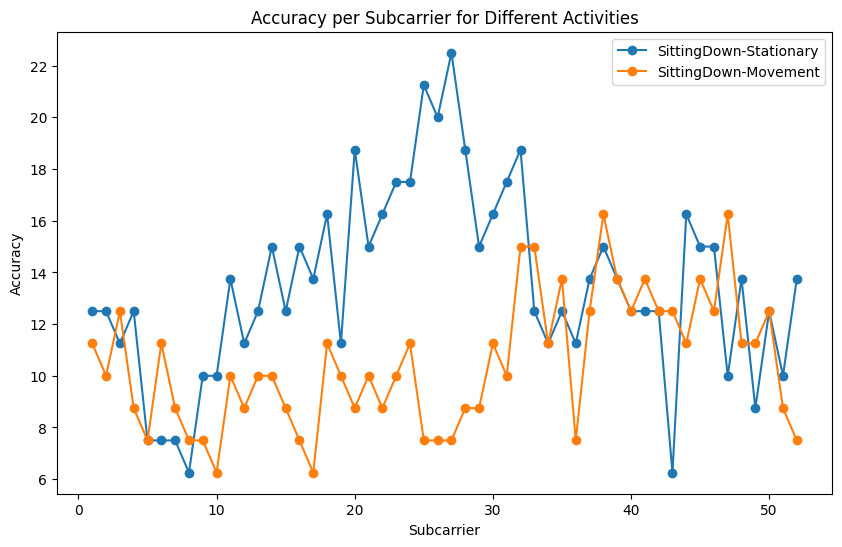

In [77]:
plt.figure(figsize=(10, 6))
for activity in activities:
    if activity == "SittingDown-Stationary" or activity == "SittingDown-Movement":
        activity_results = results[results["activity"] == activity]
        plt.plot(activity_results["subcarrier"], activity_results["accuracy"], label=activity, marker='o', linestyle='-')

plt.xlabel('Subcarrier')
plt.ylabel('Accuracy')
plt.title('Accuracy per Subcarrier for Different Activities')
plt.legend()
plt.show()

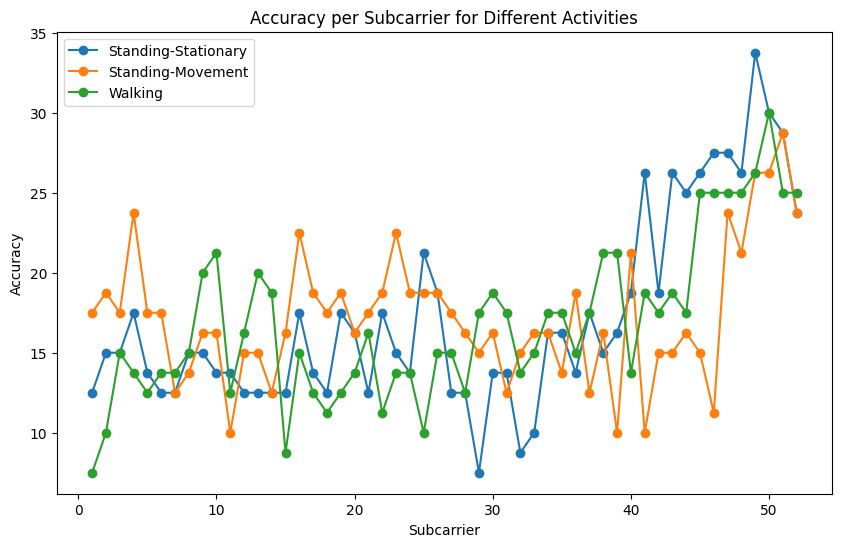

In [80]:
plt.figure(figsize=(10, 6))
for activity in activities:
    if activity != "SittingDown-Stationary" and activity != "SittingDown-Movement":
        activity_results = results[results["activity"] == activity]
        plt.plot(activity_results["subcarrier"], activity_results["accuracy"], label=activity, marker='o', linestyle='-')

plt.xlabel('Subcarrier')
plt.ylabel('Accuracy')
plt.title('Accuracy per Subcarrier for Different Activities')
plt.legend()
plt.show()

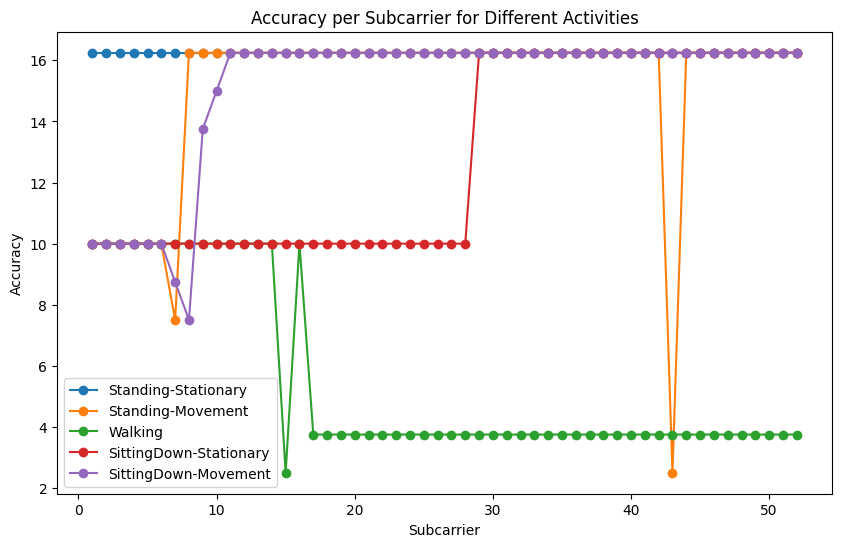

In [110]:
plt.figure(figsize=(10, 6))
for activity in activities:
    activity_results = results[results["activity"] == activity]
    plt.plot(activity_results["subcarrier"], activity_results["accuracy"], label=activity, marker='o', linestyle='-')

plt.xlabel('Subcarrier')
plt.ylabel('Accuracy')
plt.title('Accuracy per Subcarrier for Different Activities')
plt.legend()
plt.show()